## Debuging FAS

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from heuristic_problems import *
from graph import *

### Debugging: basics

In [23]:
n_node=20
n_edges=60
_hash=np.random.choice(n_node**2,n_edges,replace=False)
edges=np.zeros((n_edges,2),dtype=int)
edges[:,0]=np.floor(_hash/n_node)
edges[:,1]=_hash % n_node

g=DirectedGraph(n_node, edges).reduced_graph()
print(g.edges.T)
print(g.scc_ind)

print(g.parents_of)
print(g.children_of)

[[ 0  0  1  2  2  2  2  3  3  4  4  5  5  5  5  6  7  7  8  8  8  8  8  8
   8  9  9  9  9 10 10 10 11 13 14 14 15 15 16 17 17 17 18 18 19 19 19 19
  19]
 [ 6 17 19  3 13 14 16 15 16  3 19  2  3  8 10 14  0  6  2  4  7 10 14 16
  18  6  7 11 15  0 11 13 13 16  7  9  6 13  5  2 11 14  1 14  6 10 11 13
  16]]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
{0: [7, 10], 1: [18], 2: [5, 8, 17], 3: [2, 4, 5], 4: [8], 5: [16], 6: [0, 7, 9, 15, 19], 7: [8, 9, 14], 8: [5], 9: [14], 10: [5, 8, 19], 11: [9, 10, 17, 19], 12: [], 13: [2, 10, 11, 15, 19], 14: [2, 6, 8, 17, 18], 15: [3, 9], 16: [2, 3, 8, 13, 19], 17: [0], 18: [8], 19: [1, 4]}
{0: [6, 17], 1: [19], 2: [3, 13, 14, 16], 3: [15, 16], 4: [3, 19], 5: [2, 3, 8, 10], 6: [14], 7: [0, 6], 8: [2, 4, 7, 10, 14, 16, 18], 9: [6, 7, 11, 15], 10: [0, 11, 13], 11: [13], 12: [], 13: [16], 14: [7, 9], 15: [6, 13], 16: [5], 17: [2, 11, 14], 18: [1, 14], 19: [6, 10, 11, 13, 16]}


In [24]:
fas=MinimumFeedbackArc(g)
print(fas.h)
print(fas.h_of_node)
print(fas.energy)
print(fas.fas_ind)

[ 6 13 18  7 10  1  4  0 15  2 17 16 19  3  5 14  9 11  8 12]
[ 7  5  9 13  6 14  0  3 18 16  4 17 19  1 15  8 11 10  2 12]
28
[ 0  4  7  8 11 12 14 17 18 19 20 21 22 23 24 25 26 28 31 32 34 36 37 39
 44 45 47 48]


### Degugging step & energy change

In [27]:
n_step=1000

for i in range(n_step):
    move_parent=bool(n_step % 2)
    step=fas.propose_step(move_parent=move_parent)
    #print(step)
    fas.make_local_step(step)
    
    e_correct=fas.calculate_energy()
    e_actual=fas.energy
    
    if e_correct!=e_actual:
        print("e_correct=%d, e_actual=%d" % (e_correct, e_actual))
    

### Algorithms

Load graphs

In [43]:
# load florida graph
# i j: i goes into j's mouth
n_node=128
names=np.loadtxt("data/florida_names.txt",dtype=str,delimiter="\"")[:,1]
edges=np.loadtxt("data/florida.txt")[:,[0,1]].astype(int)-1
g=DirectedGraph(n_node,edges,names=names)
g,double=g.reduced_graph(return_double_edges=True)
print(double.T)
print(len(g.edges))


[[ 15  16  17  18  19  20  21  22  23  24  25  26  29  31  33  34  35  37
   38  39  40  43  44  47  48  49  50  59  60  61  65  90  95  98  99 122
  122 122 122 122 122 122 122 122 123 123 123 123 123 123 123 123 123 123
  123 123 123 123 123 123 123 123]
 [122 122 122 122 122 122 122 122 123 123 123 122 123 123  60 123 123 123
  123 123 123 123 123 123 123 123 123  61  33  59  98 123  99  65  95  15
   16  17  18  19  20  21  22  26  23  24  25  29  31  34  35  37  38  39
   40  43  44  47  48  49  50  90]]
2044


In [ ]:
# load yeast graph
# i j: 

Simulated annealing

In [115]:
ts=np.arange(100,dtype=int)+1
move_each_step=len(g.edges)
betas=0.1*np.log(ts)
inspect=10
rejected=np.zeros(len(ts)+1,dtype=int)
energies=np.zeros(len(ts)+1)

fas=MinimumFeedbackArc(g)
energies[0]=fas.energy

min_energy=fas.energy
min_h=fas.h.copy()
min_h_of_node=fas.h_of_node.copy()
min_fas_ind=fas.fas_ind.copy()

for t,beta in zip(ts,betas):
    if t % inspect==0:
        print("t=%d, beta=%.5f, e=%d" % (t,beta,fas.energy) )
    for i in range(move_each_step):
        move_parent=bool(i % 2)
        step=fas.propose_step(move_parent=move_parent)
        if (step.energy_change<0 or np.random.rand()<np.exp(-beta*step.energy_change)):
            fas.make_local_step(step)
        else:
            rejected[t]+=1
        if fas.energy<min_energy:
            min_energy=fas.energy
            min_h=fas.h.copy()
            min_h_of_node=fas.h_of_node.copy()
            min_fas_ind=fas.fas_ind.copy()
    energies[t]=fas.energy

print(min_energy)
print(min_h)

t=10, beta=0.23026, e=9
t=20, beta=0.29957, e=11
t=30, beta=0.34012, e=7
t=40, beta=0.36889, e=7
t=50, beta=0.39120, e=8
t=60, beta=0.40943, e=9
t=70, beta=0.42485, e=8
t=80, beta=0.43820, e=7
t=90, beta=0.44998, e=9
t=100, beta=0.46052, e=8
6
[125   7  23   1   8  10  13   6   4   0  24  34  25  47  38  39   5   3
  12   2   9 124  14  15  41  16  19  18  40  37  32  20  17  22  42  45
  44  21  31  26  70 118  27  90  30  29  36  35  48  43  66  92  94  74
  73  49  71  72  58  50  64  11  68  67  28  46  33  96  80  83  93  61
  62  63  95  99  82  56  88  57  81  51  84  97  98  53 121  65  89  87
  69  79  76 119 115 105 113 106  77 109  59  78  85 100 102  75 103 117
  55  60  54  91  86 104  52 120 116 110 107 114 112 108 111 101 122 123
 127 126]


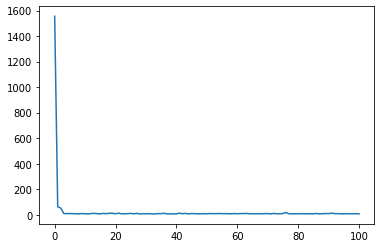

In [116]:
plt.figure()
plt.plot(np.arange(len(energies)), energies)
plt.show()

Extremal optimization

Receipe:

1. Find energy of each node, i.e., # of edges pointing upwards
2. Rank, pick a node
3. Send the node to top of 

In [178]:
ts=np.arange(100*g.n_node,dtype=int)+1
inspect=1000
energies=np.zeros(len(ts)+1)

fas=MinimumFeedbackArc(g)
energies[0]=fas.energy

tau=1.4
print("tau=%.5f" % tau)
probs=(np.arange(len(fas.graph.edges))+1).astype(float)**(-tau)

min_energy=fas.energy
min_h=fas.h.copy()
min_h_of_node=fas.h_of_node.copy()
min_fas_ind=fas.fas_ind.copy()

def normalize(arr):
    return arr/np.sum(arr)

def rankdata(arr,small_to_large=True):
    if small_to_large:
        return np.argsort(np.argsort(arr))
    else:
        return len(arr)-np.argsort(np.argsort(arr))-1

for t in ts:
    if t % inspect==0:
        print("t=%d, e=%d, min_e=%d" % (t,fas.energy,min_energy) )
    fas_edges=fas.graph.edges[fas.fas_ind]
    es=[fas.calculate_energy_change(p,c,move_parent=bool(t%2)) for p,c in fas_edges]
    ranks=rankdata(es,small_to_large=True)
    p,c=fas_edges[np.random.choice(len(fas_edges),p=normalize(probs[ranks]))]
    
    
#     fas_children_of={}
#     _={}
#     for p,c in fas_edges:
#         try:
#             fas_children_of[p].append(c)
#         except KeyError:
#             fas_children_of[p]=[c]
#     fas_children_h_rank={p:rankdata(fas_children_of[p],small_to_large=False) for p in fas_children_of}
    
#     _={p:{c:k for c,k in zip(fas_children_of[p],fas_children_h_rank[p])} for p in fas_children_of}
#     ks=[_[p][c] for p,c in fas_edges]
#     p,c=fas_edges[np.random.choice(len(fas_edges),p=normalize(probs[ks]))]

#     nodes_candidates,es=np.unique(fas_edges[:,0], return_counts=True)  
#     #print(nodes_candidates,es)
#     _rank=len(nodes_candidates)-rankdata(es)-1 # large to small
#     #print(_rank)
#     p=np.random.choice(nodes_candidates,p=normalize(probs[_rank]))
#     c=fas.graph.children_of[p][np.argmin(fas.h_of_node[fas.graph.children_of[p]])]
#     # c=np.random.choice(fas_edges[fas_edges[:,0]==p][:,1])


    step=MinimumFeedbackArc.FASStep(p,c,floor0=False,move_parent=True)
    fas.make_local_step(step)
    
    if fas.energy<min_energy:
        min_energy=fas.energy
        min_h=fas.h.copy()
        min_h_of_node=fas.h_of_node.copy()
        min_fas_ind=fas.fas_ind.copy()
    
    fas_edges=fas.graph.edges[fas.fas_ind]
    nodes_candidates,es=np.unique(fas_edges[:,1], return_counts=True)  
    _rank=len(nodes_candidates)-rankdata(es)-1 # large to small
    c=np.random.choice(nodes_candidates,p=normalize(probs[_rank]))
    p=fas.graph.parents_of[c][np.argmax(fas.h_of_node[fas.graph.parents_of[c]])]
    step=MinimumFeedbackArc.FASStep(p,c,floor0=False,move_parent=True)
    fas.make_local_step(step)
    
#     e_correct=fas.calculate_energy()
#     e_actual=fas.energy
    
#     if e_correct!=e_actual:
#         print("e_correct=%d, e_actual=%d" % (e_correct, e_actual))
    
    if fas.energy<min_energy:
        min_energy=fas.energy
        min_h=fas.h.copy()
        min_h_of_node=fas.h_of_node.copy()
        min_fas_ind=fas.fas_ind.copy()
    energies[t]=fas.energy

print("min_e=%d" % min_energy)
    


tau=1.40000
t=1000, e=346, min_e=17
t=2000, e=23, min_e=10
t=3000, e=280, min_e=7
t=4000, e=174, min_e=7
t=5000, e=24, min_e=7
t=6000, e=42, min_e=7
t=7000, e=26, min_e=6
t=8000, e=343, min_e=6
t=9000, e=43, min_e=6
t=10000, e=232, min_e=6
t=11000, e=38, min_e=6
t=12000, e=221, min_e=6
min_e=6


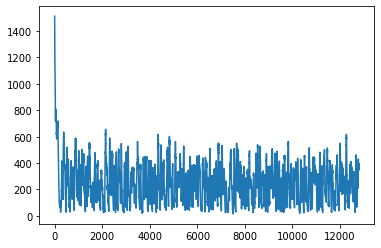

In [175]:
plt.figure()
plt.plot(np.arange(len(energies)), energies)
plt.show()

Visualize:

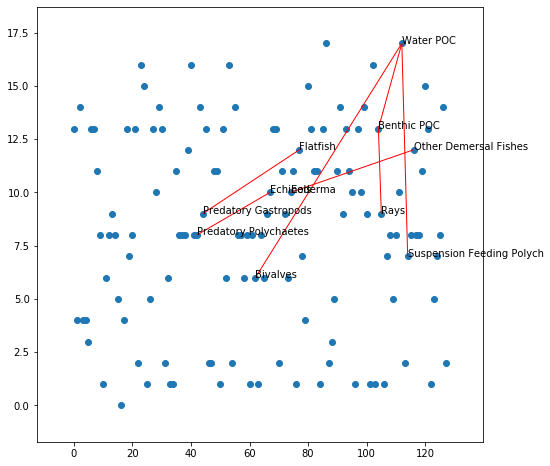

In [152]:
from matplotlib.collections import LineCollection 
ys=fas.calculate_levels(min_fas_ind)
xs=np.random.permutation(g.n_node)
xy=np.array(list(zip(xs,ys)))

plt.figure(figsize=(8,8))
plt.scatter(xs,ys)

ff_edge_ind=np.setdiff1d(np.arange(len(fas.graph.edges)),min_fas_ind)
lines=LineCollection([xy[fas.graph.edges[ind]] for ind in ff_edge_ind],linewidth=1)
ax = plt.gca()
#ax.add_collection(lines)

lines=LineCollection([xy[fas.graph.edges[ind]] for ind in min_fas_ind],linewidth=1,colors='red')
ax.add_collection(lines)


inds=np.unique(fas.graph.edges[min_fas_ind])
for x,y,name in zip(xs[inds],ys[inds],names[inds]):
    
    plt.text(x,y,name)


ax.autoscale()
ax.margins(0.1)
plt.show()


### Debugging graph

(Restrict to directed graph for this project)

In [32]:
n_node=10
n_edges=30
_hash=np.random.choice(n_node**2,n_edges,replace=False)
edges=np.zeros((n_edges,2),dtype=int)
edges[:,0]=np.floor(_hash/n_node)
edges[:,1]=_hash % n_node
print(edges.T)

[[9 9 5 6 4 0 6 2 4 2 4 1 1 4 3 2 8 9 6 5 7 5 0 3 3 3 5 6 1 1]
 [2 3 7 1 4 0 7 8 6 7 8 7 3 1 6 6 5 0 0 1 4 2 1 4 7 2 0 4 5 4]]


In [33]:
g=DirectedGraph(n_node, edges)

In [34]:
print(g.edges.T)

[[0 1 1 1 1 2 2 2 3 3 3 3 4 4 4 5 5 5 5 6 6 6 6 7 8 9 9 9]
 [1 3 4 5 7 6 7 8 2 4 6 7 1 6 8 0 1 2 7 0 1 4 7 4 5 0 2 3]]


In [35]:
print(g.scc_ind)

[0 0 0 0 0 0 0 0 0 1]


In [39]:
g_reduced=g.reduced_graph()

print(g_reduced.edges.T)
print(g_reduced.scc_ind)


[[0 1 1 2 2 2 3 3 3 3 4 5 5 5 6 6 6 7 8 9 9 9]
 [1 3 7 6 7 8 2 4 6 7 8 0 2 7 0 1 7 4 5 0 2 3]]
[0 0 0 0 0 0 0 0 0 1]


### Misc

In [7]:
bool()

True

In [148]:
def rankdata(arr,small_to_large=True):
    if small_to_large:
        return np.argsort(np.argsort(arr))
    else:
        return len(arr)-np.argsort(np.argsort(arr))-1

a=[4.5,3.5,8,1,0.4]
print(rankdata(a))
print(rankdata(a,small_to_large=False))


[3 2 4 1 0]
[1 2 0 3 4]


In [104]:
np.argmin(a)

4